# HW 10 CLUSTERING BUSINESS

## cluster time trends in NYC businesses: 
### DATA
#### Census Business data:
download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



#### NYC zip codes shape file is here
http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [2]:
import numpy as np
import pandas as pd
import json
import zipfile 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gp
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from descartes import PolygonPatch

%matplotlib inline

In [3]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

### Data Cleaning

In [4]:
with open('nyc-zip-code-tabulation-areas-polygons.geojson') as zipdata:    
    data = json.load(zipdata)

In [5]:
zipcode = []
for feature in data['features']:
    zipcode.append(str(feature['properties']['postalCode']))

In [6]:
zdict = {}
for i in range(1994, 2014):
    if i in range(1998, 2003):
        fname = 'zbp' + str(i)[2:] + 'totals.zip'
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip', '.txt')))
        df = df.rename(columns={'ZIP': 'zip', 'EST': str(i)})
        df = df[(df.zip.astype(str).isin(zipcode))]
        zdict['{}'.format(i)] = df[['zip', str(i)]]
    else:
        fname = 'zbp' + str(i)[2:] + 'totals.zip'
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip', '.txt')))
        df = df.rename(columns={'est': str(i)})
        df = df[(df.zip.astype(str).isin(zipcode))]
        zdict['{}'.format(i)] = df[['zip', str(i)]]

In [16]:
yr = range(1994,2014)
concat = []
for year in yr:
    concat.append(zdict[str(year)])
df = reduce(lambda left, right: pd.merge(left, right, on='zip', how='inner'), concat)

In [17]:
df = df.set_index('zip')
df.shape

(230, 20)

In [18]:
# Whitening
df1 = df.dropna()
for i in range(len(df1)):
    df1.iloc[i] = (df1.iloc[i]-np.mean(df1.iloc[i]))/np.std(df1.iloc[i])

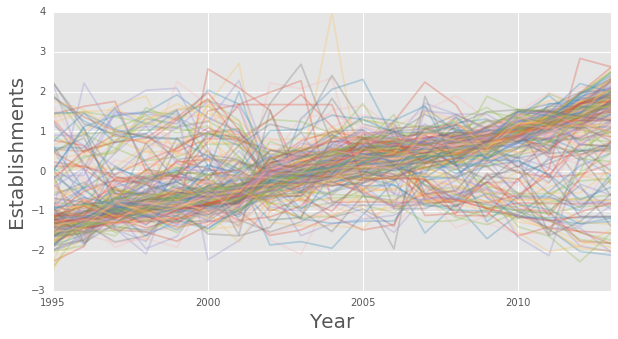

In [30]:
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,1,1) 
plt.style.use('ggplot')
for i in range(len(df1)):
    plt.plot(range(1994,2014),df1.iloc[i], alpha = 0.3)
plt.axis([1995, 2013, -3,4]) 
plt.ylabel('Establishments',fontsize=20)
plt.xlabel('Year',fontsize=20)

### K means cluster

2 clusters: 0.561611135742
3 clusters: 0.533249963188
4 clusters: 0.42388512067
5 clusters: 0.273433054428
6 clusters: 0.255272048394
7 clusters: 0.216231767055
8 clusters: 0.162499426442
9 clusters: 0.154985096268
10 clusters: 0.17527424757
11 clusters: 0.155987778223
Best for 2 clusters: 0.561611135742


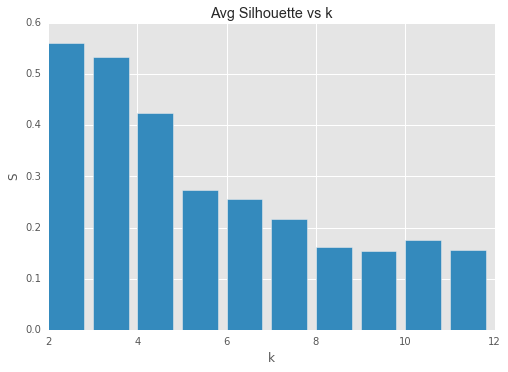

In [29]:
s=[0]*10
for k in range(0,10):
    est=KMeans(n_clusters=k+2,n_init=150)
    est.fit(df1)
    s[k]=silhouette_score(df1, est.labels_)
    print('{0} clusters: {1}'.format(k+2,s[k]))
k=np.argmax(s)    
est=KMeans(n_clusters=k+2,n_init=100)
est.fit(df1)
labels=est.labels_
plt.figure()
plt.bar(range(2,12),s)
plt.xlabel('k')
plt.ylabel('S')
plt.title('Avg Silhouette vs k')
print('Best for {0} clusters: {1}'.format(k+2,silhouette_score(df1, labels)))

In [42]:
def cluster_plot(n):

    def cluster(n, dataset):
        est = KMeans(n_clusters=n, n_init=100)
        est.fit(df1)
        labels = est.labels_
        df_label = pd.DataFrame({'label': labels})
        df_label.index = df1.index
        df_pass = df1.join(df_label)
        return df_pass

    def cluster_ts(n, df_pass):
        plt.figure(figsize=(10, 5))
        for i in range(len(df1)):
            plt.plot(range(1994, 2014), df1.iloc[i], 'grey', alpha=0.2)
        for i in range(n):
            data_byl = df_pass[df_pass['label'] == i]
            m = len(data_byl)
            sum_zip = 0
            for i in range(m):
                sum_zip = sum_zip + data_byl.iloc[i]
            avg_zip = sum_zip[0:len(sum_zip) - 1] / m
            plt.plot(range(1994, 2014), avg_zip, linewidth=15, alpha=0.8)
        plt.axis([1995, 2013, -3, 4])
        plt.ylabel('Establishments', fontsize=20)
        plt.xlabel('Year', fontsize=20)

    def cluster_map(n, df_pass):
        zip_plot = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
        zip_data = pd.DataFrame(
            {'postalCode': df1.index, 'label': list(df_pass['label'])})
        for i in range(len(zip_plot)):
            zip_plot['postalCode'][i] = int(zip_plot['postalCode'][i])
        zip_plot = pd.merge(zip_plot, zip_data)
        f = plt.figure(figsize=(10, 8))
        zip_plot.plot(column='label', categorical=True, legend=True, colormap='YlGnBu' ,alpha=0.7)

    cluster_n = cluster(n,df1)
    cluster_ts(n,cluster_n)
    cluster_map(n,cluster_n)

/Users/Dexter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


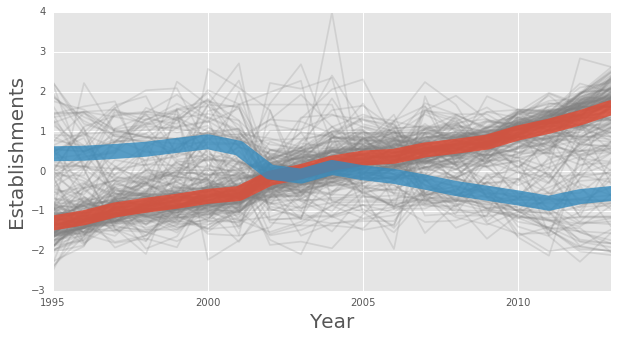

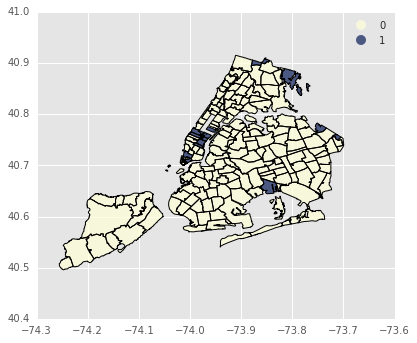

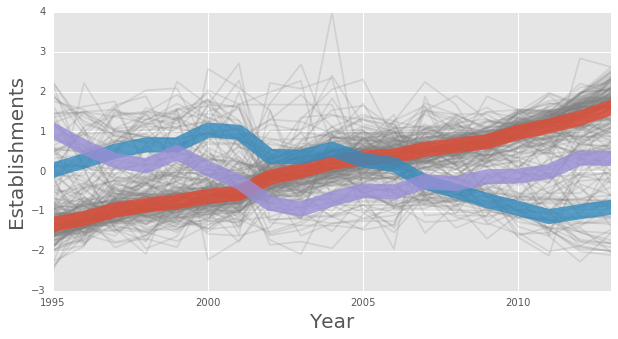

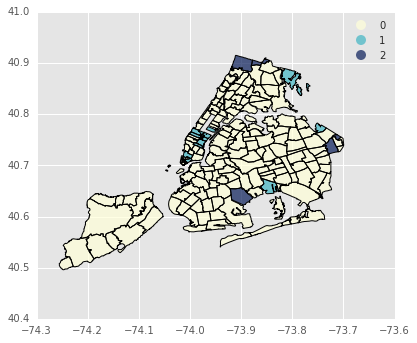

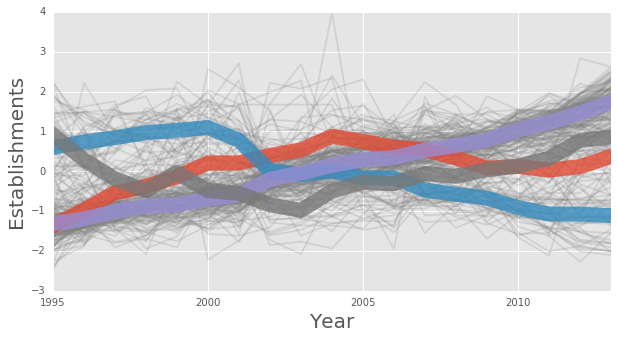

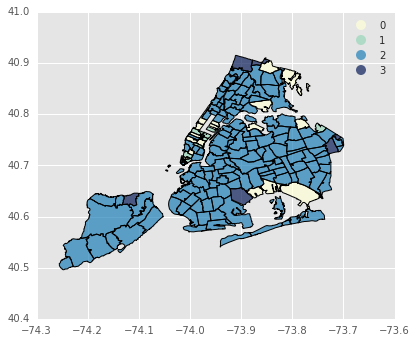

In [43]:
for i in range(2,5):
    cluster_plot(i)

### DBscan cluster

/Users/Dexter/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


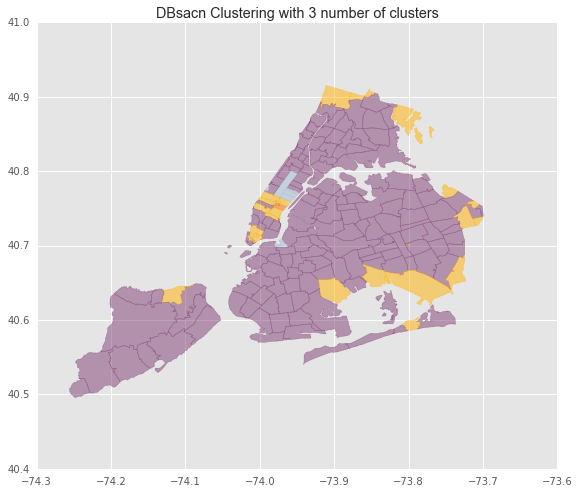

In [44]:
db = DBSCAN(eps=2).fit(df1.values)
labels = (db.labels_).astype(int)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
cluster = labels
clustered_zips = pd.DataFrame({'zip':df1.index, 'cluster':cluster})
fig = plt.figure(figsize=(10,8))
color = kelly_colors_hex[3]
for i in data['features']:
    poly = i['geometry']
    postcode = int(i['properties']['postalCode'])
    ax = fig.gca()
    if postcode in list(df1.index):
        color1 = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color1, ec=color1, alpha=0.5 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5 ))
ax.axis('scaled')

ground = mpatches.Patch(color=color, alpha=0.5, label='Ground')
plt.legend()
plt.title('DBsacn Clustering with %s number of clusters'%(n_clusters))

### Comparison
By looking at the map output of the two algorithms, we can observe that the commercial part in midtown Manhattan is classified as the same cluster with some area in bronz, which doesn't make any sense. Hence,it can be infer that the k means cluster method has a better performance on our data.



### Interpretation
From the result of kmeans 3 cluster, we can see that the businesses has been increased in most areas of the City.
We also notice that large part of manhattan does not show growth over the time. Possible reason might be that capacity limit has been reached.